# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from models import *
%matplotlib inline

np.random.seed(2512517)

## Neural network integrators
Let $q(t)=(x(t),v(t))\in\mathbb{R}^{2d}$ be the state vector. Two methods are implemented to advance this state vector in time:

### Multistep neural network
The `MultistepNNInetgrator` class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction. The neural network $\Phi$ can take different form:
* it can simply be a set of dense layers or
* it can be a two-layer LSTM network, followed by a dense layer as in [https://arxiv.org/abs/2004.06493](https://arxiv.org/abs/2004.06493)

### Hamiltonian neural network integrator
Alternatively, the `HamiltonianNNIntegrator` implements a single-step Stoermer-Verlet method for a Hamiltonian system, following the ideas in [https://arxiv.org/abs/1906.01563](https://arxiv.org/abs/1906.01563). In this case the update $q^{(t)}\mapsto q^{(t+\Delta t)}$ takes the form:

$$
\begin{aligned}
v^{(t+\Delta t/2)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t)}\right)\\[1ex]
x^{(t+\Delta t)} &= x^{(t)} + \Delta t \frac{\partial T}{\partial v}\left(v^{(t+\Delta t/2)}\right)\\[1ex]
v^{(t+\Delta t)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t+\Delta t)}\right)
\end{aligned}
$$

Assuming that the Hamiltonian $H(x,v) = T(v) + V(x)$ is separable, the kinetic energy $T(v)$ and potential energy $V(x)$ are represented by neural networks.

In [2]:
class NNIntegrator(object):
    '''Base class for neural network based integrators
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: number of multisteps
    '''
    def __init__(self,dynamical_system,dt,nsteps):
        self.dynamical_system = dynamical_system
        self.dt = dt        
        self.dim = 2*self.dynamical_system.dim
        self.nsteps = nsteps
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def set_state(self,x,v):
        '''Set the current state of the integrator
        
        :arg x: Array of size nsteps x dim with initial positions
        :arg v: Array of size nsteps x dim with initial velocities
        '''
        self.xv[0,:,:self.dim//2] = x[:,:]
        self.xv[0,:,self.dim//2:] = v[:,:]
        
    @property
    def x(self):
        '''Return the current position vector (as a d-dimensional array)'''
        return self.xv[0,-1,:self.dim//2]

    @property
    def v(self):
        '''Return the current velocity vector (as a d-dimensional array)'''
        return self.xv[0,-1,self.dim//2:]
    
    def integrate(self,n_steps):
        '''Carry out a given number of integration steps
        
        :arg n_steps: number of integration steps
        '''
        for k in range(n_steps):
            x_pred = np.asarray(self.model.predict(self.xv)).flatten()
            self.xv = np.roll(self.xv, -1, axis=1)
            self.xv[0,-1,:] = x_pred[:]
            
    def energy(self):
        return self.dynamical_system.energy(self.x,self.v)

class MultistepNNIntegrator(NNIntegrator):
    '''Multistep integrator. Use a neural network to predict the next state, given
    a number of previous states
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: Number of steps of the timestepping method
    :arg dense_layers: neural network layers used to predict the next state
    '''
    def __init__(self,dynamical_system,dt,nsteps,dense_layers):
        super().__init__(dynamical_system,dt,nsteps)
        self.dim = 2*self.dynamical_system.dim
        self.dense_layers = dense_layers
        self._build_model()
    
    def _build_model(self):
        inputs = keras.Input(shape=(self.nsteps,self.dim))
        q_n = tf.unstack(inputs,axis=1)[-1]        
        output_layer = keras.layers.Dense(self.dim)
        x = inputs
        for layer in dense_layers:
            x = layer(x)
        x = output_layer(x)
        x = keras.layers.Rescaling(self.dt)(x)
        outputs = keras.layers.Add()([q_n,x])
        self.model = keras.Model(inputs=inputs,outputs=outputs)
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=1.E-4))
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def call(self, inputs, training=False):
        '''Evaluate model
        
        Split the inputs = (q_n,p_n) into position and momentum and 
        return the state (q_{n+1},p_{n+1}) at the next timestep.
        
        Note that the expected tensor shape is B x 1 x 2d to be compatible with
        the non-symplectic update 
        
        :arg inputs: state (q_n,p_n) as a B x 1 x 2d tensor
        '''
        
        input_shape = tf.shape(inputs)
        # Extract q_n and p_n from input
        qp_old = tf.unstack(tf.reshape(inputs, (input_shape[0],input_shape[2],)),axis=-1)
        q_old = tf.stack(qp_old[:self.dim//2],axis=-1)
        p_old = tf.stack(qp_old[self.dim//2:],axis=-1)
        q_new, p_new = self.verlet_step(q_old,p_old)        
        # Combine result of Verlet step into tensor of correct size
        outputs = tf.stack([q_new,p_new],axis=-1)        
        return outputs

class HamiltonianNNIntegrator(NNIntegrator):
    '''Neural network integrator based on the Hamiltonian Stoermer-Verlet update'''
    def __init__(self,dynamical_system,dt,V_pot_layers,T_kin_layers):
        super().__init__(dynamical_system,dt,1)
        self.V_pot_layers = V_pot_layers
        self.T_kin_layers = T_kin_layers
        self._build_model()
    
    def _build_model(self):
        self.model = VerletModel(self.dim,self.dt,
                                 self.V_pot_layers,
                                 self.T_kin_layers)
        self.model.build(input_shape=(None,1,self.dim))
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=1.E-4))


### Set up system
Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

In [3]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for multistep neural network integrator
nsteps = 6

# use Hamiltonian model?
use_hamiltonian = True
# use LSTM network for multistep integrator?
use_LSTM = True

# dynamical system to integrate
harmonic_oscillator = HarmonicOscillator(mass,k_spring)
# Verlet integrator used to generate data
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_verlet)

if use_hamiltonian:
    V_pot_layers = [keras.layers.Dense(16,activation='sigmoid'),
                    keras.layers.Dense(16,activation='sigmoid'),
                    keras.layers.Dense(16,activation='sigmoid')]
    T_kin_layers = [keras.layers.Dense(16,activation='sigmoid'),
                    keras.layers.Dense(16,activation='sigmoid'),
                    keras.layers.Dense(16,activation='sigmoid')]
    nn_integrator = HamiltonianNNIntegrator(harmonic_oscillator,dt,V_pot_layers,T_kin_layers)    
else:
    if use_LSTM: 
        # Use two layers of LSTMs followed by a dense layer
        dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Dense(32,activation='tanh')]
    else:
        # Just use several dense layers
        dense_layers = [keras.layers.Flatten(),
                        keras.layers.Dense(32,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]


    nn_integrator = MultistepNNIntegrator(harmonic_oscillator,nsteps,dt,
                                          dense_layers)

# visualise the neural network model
nn_integrator.model.summary()
#keras.utils.plot_model(nn_integrator.model, show_shapes=True)

Model: "verlet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  32        
                                                                 
 dense_1 (Dense)             multiple                  272       
                                                                 
 dense_2 (Dense)             multiple                  272       
                                                                 
 dense_3 (Dense)             multiple                  32        
                                                                 
 dense_4 (Dense)             multiple                  272       
                                                                 
 dense_5 (Dense)             multiple                  272       
                                                                 
 dense_6 (Dense)             multiple                 

## Data generator
The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [4]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.x[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.v[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
BATCH_SIZE=64
data_generator = DataGenerator(nn_integrator,verlet_integrator)
train_batches = data_generator.dataset.batch(BATCH_SIZE)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [5]:
EPOCHS=200
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

Epoch 1/200
100/100 [==============================] - ETA: 1:27 - loss: 1.675 - ETA: 4s - loss: 1.9079  - ETA: 4s - loss: 1.989 - ETA: 4s - loss: 2.044 - ETA: 3s - loss: 2.071 - ETA: 3s - loss: 2.057 - ETA: 3s - loss: 2.052 - ETA: 3s - loss: 2.042 - ETA: 3s - loss: 2.028 - ETA: 3s - loss: 1.965 - ETA: 3s - loss: 1.950 - ETA: 3s - loss: 1.943 - ETA: 3s - loss: 1.938 - ETA: 2s - loss: 1.935 - ETA: 2s - loss: 1.939 - ETA: 2s - loss: 1.943 - ETA: 2s - loss: 1.939 - ETA: 2s - loss: 1.941 - ETA: 2s - loss: 1.933 - ETA: 2s - loss: 1.938 - ETA: 2s - loss: 1.927 - ETA: 2s - loss: 1.925 - ETA: 2s - loss: 1.932 - ETA: 2s - loss: 1.926 - ETA: 2s - loss: 1.923 - ETA: 1s - loss: 1.920 - ETA: 1s - loss: 1.914 - ETA: 1s - loss: 1.915 - ETA: 1s - loss: 1.915 - ETA: 1s - loss: 1.913 - ETA: 1s - loss: 1.909 - ETA: 1s - loss: 1.919 - ETA: 1s - loss: 1.908 - ETA: 1s - loss: 1.907 - ETA: 1s - loss: 1.910 - ETA: 1s - loss: 1.919 - ETA: 1s - loss: 1.919 - ETA: 0s - loss: 1.924 - ETA: 0s - loss: 1.928 - ETA: 

KeyboardInterrupt: 

## Loss function
![Loss function](./loss_history.png)

## Plot trajectories generated by Verlet integrator and neural network based integrator

In [ ]:
# Final time
T_final = 32

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 1.0
v[0] = 0.0
verlet_integrator.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet = []
x_verlet = []
E_verlet = []
while t<T_final:
    t_verlet.append(t)
    E_verlet.append(verlet_integrator.energy())
    x_verlet.append(verlet_integrator.x[0])
    verlet_integrator.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
v_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
verlet_integrator.set_state(x,v)
for k in range(nn_integrator.nsteps):    
    x_initial[k,:] = verlet_integrator.x[:]
    v_initial[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))
nn_integrator.set_state(x_initial,v_initial)
t = (nn_integrator.nsteps-1)*nn_integrator.dt

# Timestepping loop
t_nn = []
x_nn = []
E_nn = []
while t<T_final:
    t_nn.append(t)
    x_nn.append(nn_integrator.x[0])
    E_nn.append(nn_integrator.energy())
    nn_integrator.integrate(1)
    t += dt

# Plot position as a function of time
plt.plot(t_verlet,x_verlet,label='Verlet',color='blue')
plt.plot(t_nn,x_nn,label='Neural network',color='red')
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position $x(t)$')
ax.set_title('Position')
plt.show()

plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)
fig, axs = plt.subplots(2,1)
axs[0].plot(t_verlet,E_verlet-E_verlet[0],label='Verlet',color='blue')
axs[1].plot(t_nn,E_nn-E_nn[0],label='Neural network',color='red')
plt.legend(loc='lower right')
for ax in axs:
    ax.set_xlabel('time $t$')
    ax.set_ylabel('energy shift $E(t)-E(t_0)$')
plt.show()

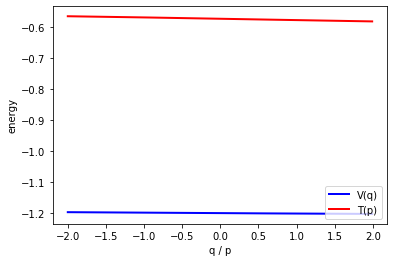

In [6]:
# Plot potential and kinetic energy (for debugging)
X = tf.expand_dims(tf.constant(np.arange(-2.0,2.0,0.01)),axis=1)

V_pot = nn_integrator.model.V_pot(X).numpy().flatten()
T_kin = nn_integrator.model.T_kin(X).numpy().flatten()
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='lower right')
plt.show()